In [1]:
import os
import sys

os.environ["SPARK_HOME"]=os.path.join(os.path.expanduser("~"),'spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

In [2]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config('spark.sql.warehouse.dir','C:\Users\qorgk\code\spark')\
    .getOrCreate()

In [3]:
print spark.version

2.0.0


In [4]:
from pyspark.sql import Row
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [17]:
_bicycle = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/seoulBicycleDailyCount_2018_201903.csv')

In [41]:
bicycle=_bicycle\
    .withColumnRenamed("date", "Date")\
    .withColumnRenamed(" count", "Count")
bicycle=bicycle.withColumn("year",bicycle.Date.substr(1, 4))
bicycle=bicycle.withColumn("month",bicycle.Date.substr(6, 2))

In [26]:
import pyspark.sql.functions as F
bicycle = bicycle\
    .withColumn('year', F.year('date'))\
    .withColumn('month', F.month('date'))

In [38]:
from pyspark.sql.functions import udf
def classifyQuarter(s):
    q=""
    if 1<=s and s< 4:
        q="Q1"
    elif 4<=s and s<7:
        q="Q2"
    elif 7<=s and s<10:
        q="Q3"
    elif 10<=s and s<=12:
        q="Q4"
    else:
        q="no"
    return q

quarter_udf = udf(classifyQuarter, StringType())

In [39]:
bicycle=bicycle.withColumn("quarter", quarter_udf(bicycle.month))

### 년도별, 분기별 대여건수 합계

In [40]:
bicycle.groupBy('year').pivot('quarter').agg({"count":"sum"}).show()

+----+-------+-------+-------+-------+
|year|     Q1|     Q2|     Q3|     Q4|
+----+-------+-------+-------+-------+
|2018| 795769|2860617|3585513|2882975|
|2019|1871935|   null|   null|   null|
+----+-------+-------+-------+-------+



### 그래프

In [32]:
sumMonthly=bicycle.groupBy('year').pivot('month').agg({"count":"sum"})

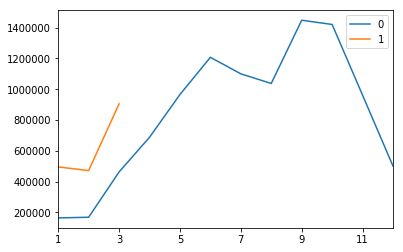

In [45]:
pdf=sumMonthly.toPandas()
my=pdf.drop('year',1).transpose()
my.plot(kind='line')

In [46]:
pdf.head()

,year,1,2,3,4,5,6,7,8,9,10,11,12
0,2018,164367,168741,462661,687885.0,965609.0,1207123.0,1100015.0,1037505.0,1447993.0,1420621.0,961532.0,500822.0
1,2019,495573,471543,904819,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 문제 S-1: RDD 훈련데이터 만들기

In [47]:
try:
    fp=os.path.join(os.environ["SPARK_HOME"],\
        'data','mllib','sample_svm_data.txt')
except:
    print("An exception occurred")

In [48]:
from pyspark.mllib.regression import LabeledPoint
trainRdd=spark.sparkContext.textFile(fp)\
    .map(lambda line: [float(x) for x in line.split(' ')])\
    .map(lambda p:LabeledPoint(p[0], p[1:]))

In [49]:
trainRdd.take(5)

[LabeledPoint(1.0, [0.0,2.52078447201548,0.0,0.0,0.0,2.004684436494304,2.000347299268466,0.0,2.228387042742021,2.228387042742023,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(0.0, [2.857738033247042,0.0,0.0,2.619965104088255,0.0,2.004684436494304,2.000347299268466,0.0,2.228387042742021,2.228387042742023,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(0.0, [2.857738033247042,0.0,2.061393766919624,0.0,0.0,2.004684436494304,0.0,0.0,2.228387042742021,2.228387042742023,0.0,0.0,0.0,0.0,0.0,0.0]),
 LabeledPoint(1.0, [0.0,0.0,2.061393766919624,2.619965104088255,0.0,2.004684436494304,2.000347299268466,0.0,0.0,0.0,0.0,2.055002875864414,0.0,0.0,0.0,0.0]),
 LabeledPoint(1.0, [2.857738033247042,0.0,2.061393766919624,2.619965104088255,0.0,2.004684436494304,0.0,0.0,0.0,0.0,0.0,2.055002875864414,0.0,0.0,0.0,0.0])]

In [50]:
fsvm=os.path.join(os.environ["SPARK_HOME"],'data','mllib','sample_libsvm_data.txt')
dfsvm = spark.read.format("libsvm").load(fsvm)

In [51]:
dfsvm.take(1)

[Row(label=0.0, features=SparseVector(692, {127: 51.0, 128: 159.0, 129: 253.0, 130: 159.0, 131: 50.0, 154: 48.0, 155: 238.0, 156: 252.0, 157: 252.0, 158: 252.0, 159: 237.0, 181: 54.0, 182: 227.0, 183: 253.0, 184: 252.0, 185: 239.0, 186: 233.0, 187: 252.0, 188: 57.0, 189: 6.0, 207: 10.0, 208: 60.0, 209: 224.0, 210: 252.0, 211: 253.0, 212: 252.0, 213: 202.0, 214: 84.0, 215: 252.0, 216: 253.0, 217: 122.0, 235: 163.0, 236: 252.0, 237: 252.0, 238: 252.0, 239: 253.0, 240: 252.0, 241: 252.0, 242: 96.0, 243: 189.0, 244: 253.0, 245: 167.0, 262: 51.0, 263: 238.0, 264: 253.0, 265: 253.0, 266: 190.0, 267: 114.0, 268: 253.0, 269: 228.0, 270: 47.0, 271: 79.0, 272: 255.0, 273: 168.0, 289: 48.0, 290: 238.0, 291: 252.0, 292: 252.0, 293: 179.0, 294: 12.0, 295: 75.0, 296: 121.0, 297: 21.0, 300: 253.0, 301: 243.0, 302: 50.0, 316: 38.0, 317: 165.0, 318: 253.0, 319: 233.0, 320: 208.0, 321: 84.0, 328: 253.0, 329: 252.0, 330: 165.0, 343: 7.0, 344: 178.0, 345: 252.0, 346: 240.0, 347: 71.0, 348: 19.0, 349: 28.0